Initialize

In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "torch"   # Must be called before importing keras. 
    # 'torch' if using GPU; tensorflow is faster otherwise and more likely to work with older snippets
import keras
import keras_tuner
import torch
import tensorflow as tf
from scipy import stats
from imblearn.over_sampling import *
import warnings

warnings.filterwarnings("ignore")

## Tested seeds 1-12 and 123 to determine which apportioned PEM days most uniformly.
## Full dataset: ratio of PEM/Not = 0.30. Best = seed 123 -> train 0.31 / val 0.29 /  test 0.29
seed = 123

# # Create requirements file
# pip list -format-freeze > requirements.txt

In [2]:
# # Testing GPU access
# ## Using pytorch because jax won't work with cuda on Windows 11, and the tensorflow installation didn't recognize the gpu
# ## However, pytorch is MUCH slower when all use the GPU.
# print("Is CUDA available:", torch.cuda.is_available())
# print("Current device:", torch.cuda.get_device_name(0))

Import data and concatenate

In [3]:
outs = pl.read_excel("Data/Outcomes/outcomes.xlsx")
preds = pl.read_csv("Data/Predictors/Sleep(1).csv")
for i in range(9):
    temp = pl.read_csv(f"Data/Predictors/Sleep({i + 2}).csv")
    preds = pl.concat([preds, temp], how = "vertical")
preds = preds.rename({"Sleep Score 4 Weeks": "Date", "Score": "Sleep Score"})

# Retain only useful columns
preds = preds.select(pl.nth(0,1,2,3,5, 6, 7))

# Convert date column to date format
preds = preds.with_columns(
    (pl.col("Date") + " 2024")
    .str.strptime(pl.Date, format="%b %e %Y")
    .alias("Date"))

Merge factors and outcome on date

In [4]:
# Note: the predictors are mnissing data for 9/24/24 due to crossing the dateline.
df = preds.join(outs, how = "inner", on = "Date")

Convert temperature changes to numeric

In [5]:
df = df.with_columns(
    pl.col("Skin Temp Change").str.strip_chars_end("°").cast(pl.Float64))

EDA (other analysis done in VS Code extension)

<Axes: >

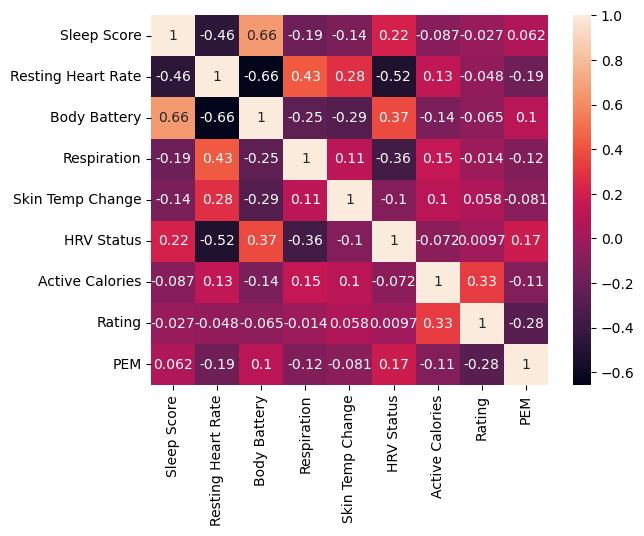

In [6]:
# Plot correlation matrix
sns.heatmap(df.to_pandas().iloc[:, 1:10].corr(), annot=True)

## Despite some collinearity, no variables appear duplicative.
## The low correlations between the outcomes and any other variable, including other outcomes,
    ## portend ill for the analysis' success.

Standardize and split data

In [7]:
scaler = StandardScaler()
dfp = df.to_pandas()
dfp.iloc[:, 1:7] = scaler.fit_transform(dfp.iloc[:, 1:7])

# Initial split between train, validation, and test sets
## Prioritizing training due to small dataset
dfp_train, dfp_test = train_test_split(dfp.iloc[:, 1:], test_size=0.3, random_state=seed)
dfp_test, dfp_val = train_test_split(dfp_test, test_size=0.5, random_state=seed)
X_train = dfp_train.iloc[:, 0:6]
y_train = dfp_train.iloc[:, -1]
X_val = dfp_val.iloc[:, 0:6]
y_val = dfp_val.iloc[:, -1]
X_test = dfp_test.iloc[:, 0:6]
y_test = dfp_test.iloc[:, -1]

Balance training data.

In [8]:
ros = SMOTE(random_state=seed)  # Same or worse result with all other types of balancing
X_train, y_train = ros.fit_resample(X_train, y_train)

Create binary classification model and search for optimal hyperparameters


In [9]:
## Each hyperparameter, including the loss, the metric, the number of layers and nodes, whether to use L2 regularization on each layer, 
## the dropout rate, the learning rate, and the L2 penalty was determined through Bayesian tuning. (Hyperband took much longer
# without producing more-promising results.)

keras.utils.set_random_seed(seed)
input_shape = (6,)

# Set hyperparamters
def build_model(hp):
        model = keras.Sequential()
        model.add(keras.layers.Input(shape = input_shape, name = "input"))
        for i in range(hp.Int("num_layers", 0, 4)):
                model.add(
                        keras.layers.Dense(
                                units=hp.Int(f"units_{i}", min_value=3, max_value=30, step=1),
                                activation = "relu",  # Tuned
                                kernel_regularizer = keras.regularizers.L2(
                                        l2 = hp.Float("L2", min_value = 0.0, max_value = 0.9, step = 0.1)),
                                kernel_initializer = keras.initializers.HeNormal()
                        )
                )
                model.add(
                        keras.layers.Dropout(hp.Float("dropout", min_value=0.0, max_value=0.9, 
                                                      step = 0.1)),  # Tuned: 0, tried through 0.6
                        )
        model.add(keras.layers.Dense(1, activation='sigmoid',
                kernel_initializer = keras.initializers.HeNormal(), 
                name = "output"))
        learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
        model.compile(
                optimizer=keras.optimizers.Adam(learning_rate = learning_rate), # Tuned
                loss='binary_crossentropy',
                metrics=['f1_score']
                )
        return model


Set up tuner

In [10]:
## Hyperband tuning took extremely long without producing better performance.
# tuner = keras_tuner.Hyperband(
#     hypermodel=build_model,
#     # objective="val_AUC",
#     objective="val_f1_score",
#     factor=3,
#     hyperband_iterations=3,
#     seed=None,
#     hyperparameters=None,
#     tune_new_entries=True,
#     allow_new_entries=True,
#     max_retries_per_trial=0,
#     max_consecutive_failed_trials=3,
#     max_epochs=200,      # 65 minutes!
#     executions_per_trial=2,
#     overwrite=True,
#     project_name="hp_tuning_F1")

tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective = keras_tuner.Objective('val_f1_score', 'max'),
    max_trials=500,     # probably overkill - runs > 15 mins
    num_initial_points=None,
    alpha=0.0001,
    beta= 2.6, # default: 2.6
    seed=seed,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=0,
    max_consecutive_failed_trials=3,
    overwrite=True,
    project_name="hp_tuning_F1_Bayes"
)

Run tuner (Delete previous results beforehand)

In [11]:
tuner.search(X_train, y_train, epochs=2, validation_data=(X_val, y_val), verbose = 0)

Get tuning results (straightforward logistic regression, although more-involved models produce same F1)

In [12]:
models = tuner.get_best_models()
best_model = models[0]
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ output (Dense)                  │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7 (28.00 B)

 Trainable params: 7 (28.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
tuner.results_summary(1)  # 123: 0.3673 for Hyperband & Bayesian

Results summary
Results in .\hp_tuning_F1_Bayes
Showing 1 best trials
Objective(name="val_f1_score", direction="max")

Trial 000 summary
Hyperparameters:
num_layers: 0
lr: 0.008347597753558379
Score: 0.3673468828201294


Train with best model, running multiple epochs, although it was unnecessary)

In [16]:
# Get the best hyperparameters.
best_hps = tuner.get_best_hyperparameters()

# Build the model with the best hyperparameters.
model = build_model(best_hps[0])

# Fit the model
# results = model.fit(x=X_train, y=y_train, epochs=1000)

callbacks = [keras.callbacks.EarlyStopping(monitor="val_f1_score", patience=100, 
                                           restore_best_weights=True)]

results = model.fit(
    X_train, 
    y_train, 
    validation_data = (X_val, y_val), 
    epochs = 1000, 
    verbose = 0,
    callbacks=callbacks,
    batch_size = 40
    )

print(f'Best validation F1: {round(max(results.history['val_f1_score']), 3)}')

test_metrics = model.evaluate(X_test, y_test, return_dict = True, verbose = 0)
print(f'Test F1: {round(test_metrics['f1_score'], 3)}')

model.save("final_model_PEM_classification.keras")  # save final model

Best validation F1: 0.367
Test F1: 0.367


Load saved model and make predictions

In [17]:
model_final = keras.saving.load_model("final_model_PEM_classification.keras")  # reload best model, built with seed = 123
predictions = model_final.predict(X_test, verbose = 0) # make predictions
predictions = predictions[:, 0] >= 0.5  # Converting from probability to binary

Plot training and validation loss and metric, which show that the model would not improve

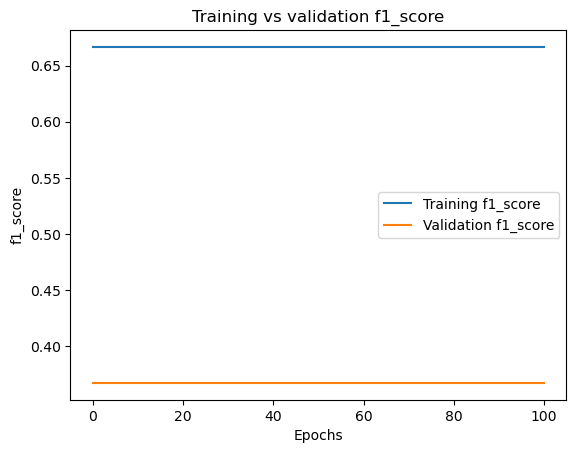

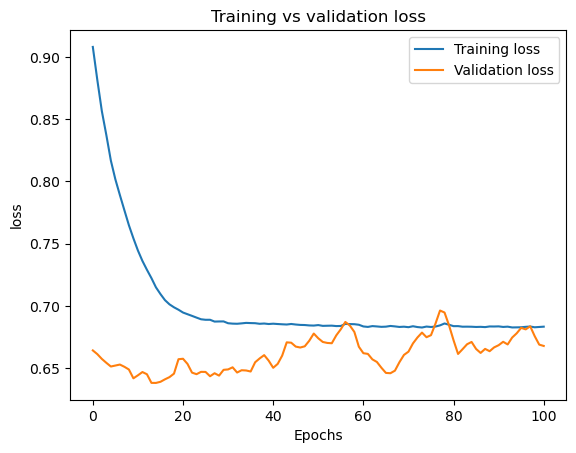

In [18]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.title(f'Training vs validation {metric}')
    plt.legend()
    plt.show()

# Plot accuracy
plot_metrics(results, 'f1_score')

# Plot loss
plot_metrics(results, 'loss')

In [19]:
print("OVERALL ACCURACY")
print(f"Accuracy: {np.mean(y_test == predictions)}")

print()
print(classification_report(y_test, predictions))

OVERALL ACCURACY
Accuracy: 0.4

              precision    recall  f1-score   support

           0       0.71      0.39      0.50        31
           1       0.17      0.44      0.25         9

    accuracy                           0.40        40
   macro avg       0.44      0.42      0.38        40
weighted avg       0.59      0.40      0.44        40



Checking correlation of predictions to actual results, using test set 

Correlation between observations and predictions: -0.142
Standard deviation of MAE: 0.49


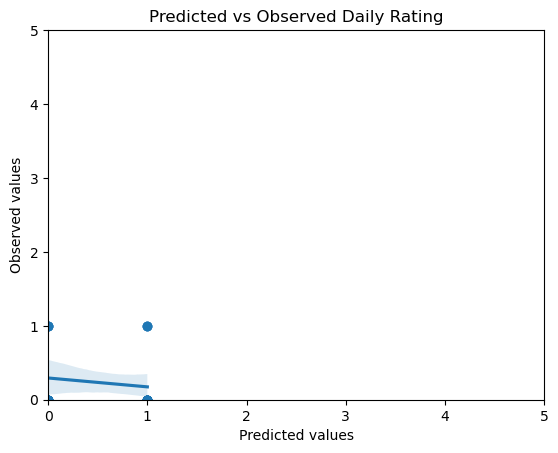

In [20]:
# Correlation and standard deviation of the errors
print(f'Correlation between observations and predictions: {round(np.corrcoef(y_test, predictions)[0][1], 3)}') 
print(f'Standard deviation of MAE: {round(np.std(np.absolute(np.subtract(y_test, predictions))), 3)}')

# Plotting lowess and linear regression lines, with 95% confidence interval for latter
sns.regplot(y = y_test, x = predictions)
plt.title('Predicted vs Observed Daily Rating')
plt.xlabel('Predicted values')
plt.ylabel('Observed values')
plt.xlim(0, 5)
plt.ylim(0,5)
plt.show()

**Discussion:** 
1) I tested tuning and training by AUC, with even worse results for both AUC and F1.
2) This model fails on both the validation and test sets, with low accuracy, low F1, and correlation in the wrong direction.
